In [1]:
from libaries import *
from data_denoising import *
from data_loading import findFiles,LoadDataSignals
from global_parameters import *
from peak_to_peak_detection import *
from time_synchronization import *
from moving_average_filter import *

#### Extract relevant files for processing


In [2]:
expected_waveform="sin"
expected_periods="9"
unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)


#### Data Loading

In [3]:
raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[0],time_axis_start=0,time_axis_end=16000)
raw.shape



(100, 2, 16000)

#### Time Synchronized Averaging (Experiments=100)

In [4]:
averaged_signal=time_synchronized_averaging(raw,threshold=500000)

DC Offset Remval (100, 2, 16000)
Raw After Null Experiments Removal:  (40, 2, 16000)


In [5]:
averaged_signal.shape

(1, 16000)

#### Moving Average

In [6]:
# Apply the Hanning filter from the slide
filtered_hanning = apply_hanning_filter(raw, trial_idx=0)

In [7]:
# Print shape to verify
print("Hanning filter (slide) shape:", filtered_hanning.shape) 

Hanning filter (slide) shape: (1, 16000)


In [8]:
filtered_uniform_moving_avg=apply_uniform_moving_average_filter(raw, trial_idx=0, window_size=11)

In [9]:
filtered_uniform_moving_avg.shape

(1, 16000)

#### Data Plotting (For Testing)

In [10]:
"""buffer = 50
for i in range(raw.shape[0]):
    current_ref_point = reference_points[i]
    if  current_ref_point != 0 :
        time_range=np.arange(current_ref_point - buffer,current_ref_point + buffer)
        plt.plot(time_range,raw[i,1,current_ref_point - buffer:current_ref_point + buffer])
        plt.scatter(current_ref_point , raw[i,1,current_ref_point])
        plt.show()
        """

'buffer = 50\nfor i in range(raw.shape[0]):\n    current_ref_point = reference_points[i]\n    if  current_ref_point != 0 :\n        time_range=np.arange(current_ref_point - buffer,current_ref_point + buffer)\n        plt.plot(time_range,raw[i,1,current_ref_point - buffer:current_ref_point + buffer])\n        plt.scatter(current_ref_point , raw[i,1,current_ref_point])\n        plt.show()\n        '

In [11]:
start=8000
end=8200

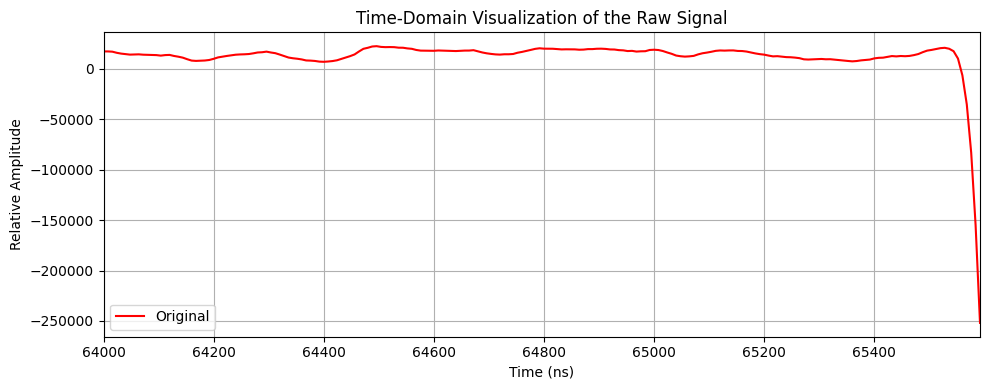

In [12]:
Fs = 125e6  # 125 MHz
Ts_ns = 1e9 / Fs  # Sampling period in nanoseconds

time_ns = np.arange(start, end) * Ts_ns

plt.figure(figsize=(10, 4))
plt.plot(time_ns, raw[0,1,start:end], label='Original', color='red')
plt.title('Time-Domain Visualization of the Raw Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Relative Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(time_ns[0], time_ns[-1])

plt.tight_layout()
plt.show()


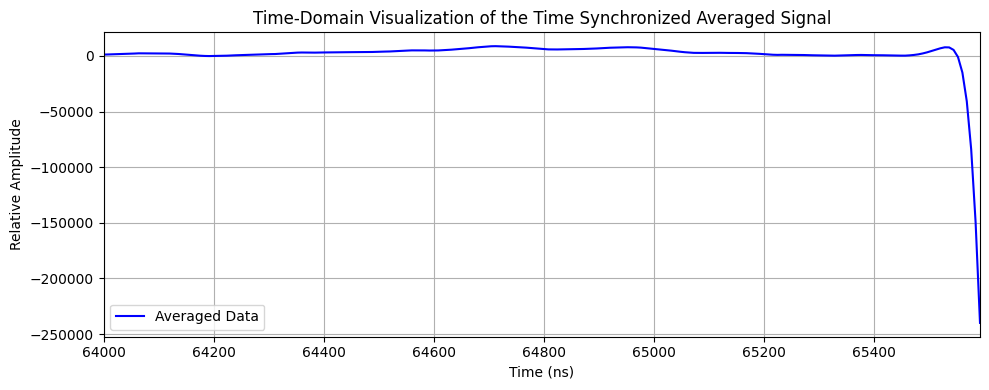

In [16]:


Fs = 125e6  # 125 MHz
Ts_ns = 1e9 / Fs  # Sampling period in nanoseconds

time_ns = np.arange(start, end) * Ts_ns

plt.figure(figsize=(10, 4))
plt.plot(time_ns, averaged_signal[0][start:end], label='Averaged Data', color='blue')
plt.title('Time-Domain Visualization of the Time Synchronized Averaged Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Relative Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(time_ns[0], time_ns[-1])

plt.tight_layout()
plt.show()



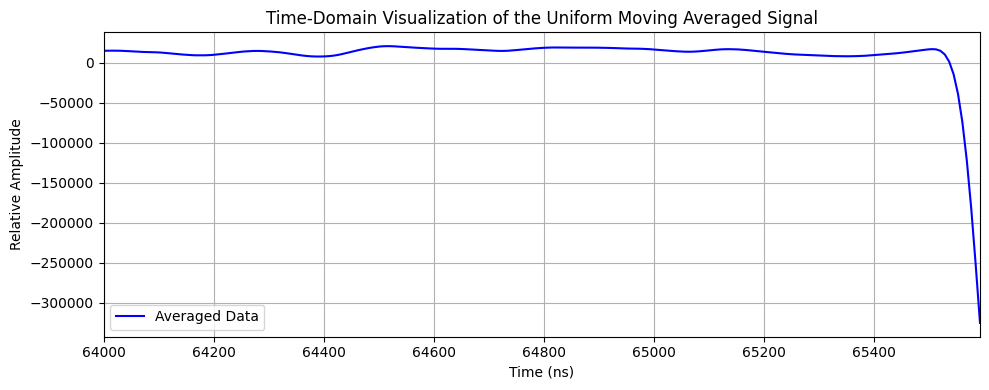

In [15]:
Fs = 125e6  # 125 MHz
Ts_ns = 1e9 / Fs  # Sampling period in nanoseconds

time_ns = np.arange(start, end) * Ts_ns

plt.figure(figsize=(10, 4))
plt.plot(time_ns, filtered_uniform_moving_avg[0][start:end], label='Averaged Data', color='blue')
plt.title('Time-Domain Visualization of the Uniform Moving Averaged Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Relative Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(time_ns[0], time_ns[-1])

plt.tight_layout()
plt.show()

